### Import Libraries 

In [1]:
# Pyton 2 and 3 support
from __future__ import division, print_function, unicode_literals

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn

%matplotlib inline

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
from skimage import transform
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
#from vis_utils import *
import random;
import math;

### Data Loading

In [3]:
# Declare the essential hyperparameters
num_epochs = 5;
batch_size = 100;
learning_rate = 0.001;

In [4]:
# Regarding the Fashion data, this time actually load the separate training and test datasets
train_dataset = pd.read_csv('data/MNIST/raw/fashion-mnist_train.csv');
test_dataset = pd.read_csv('data/MNIST/raw/fashion-mnist_test.csv');

* load the images BEFORE training so that you don't have to iterate/parse through files 
* create array for images
* create array for label
* iterate through each line and assign a label to images (index to each together) 
* download the clothing category txt file and additionally go to "eval" folder and download that file that separates data into test, training, and validation --> 
* write a function to get the labels
* write a function to convert to pixels 
* make sure it's in form of np.array 
* remember to normalize data using "mean" technique 
* can cheat and use half the data hehehehehe
* running it on paperspace will take 1 hour

In [5]:
# In Pytorch, for data loading I implement a class that inherits the Dataset type and defines
# the data reading functions and data access functions
# process data beforehand and put that data into the dataset so that when you train your model, you are not processing through the data at the same time 
# dataset defines how you access and return the data...for example, you create a dataset class with the certain images in that class
# data loader class (not as important, on the other hand, connects your dataset (acts as the delivery man while dataset class packages the data)
class FashionMNISTDataset(Dataset):
    '''Fashion MNIST Dataset'''
    # In the __init__, we load in the data from the csv file. 
    # For this dataset, I use Pandas to read it in as a dataframe, and convert it to a numpy array for indexing. 
    # Follow this by a transform function, which can be passed in as a method parameter, to transform the inputs before being returned.
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file
            transform (callable): Optional transform to apply to sample
        """
        
        data = pd.read_csv('csv_file');
        self.X = np.array(data.iloc[:, 1:]).reshape(-1, 1, 28, 28)#.astype(float);
        self.Y = np.array(data.iloc[:, 0]);
        
        del data;
        self.transform = transform;
        
    def __len__(self):
        return len(self.X);
    
    # The __getitem__ will return a single image from the loader. 
    # It takes in an index, returns that item and label with it. 
    # If the transform function is defined, apply the transformation to the item and return it.
    def __getitem__(self, idx):
        item = self.X[idx];
        label = self.Y[idx];
        
        if self.transform:
            item = self.transform(item);
        
        return (item, label); # label refers to "correct" answer

In [6]:
# Define data loaders using DataLoader module: 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True);
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True);

### The Network

Time to implement the Neural Network graph! One of the reasons why PyTorch is preferred sometimes over TensorFlow and Keras is because it defines graphs easier and makes it more intuitive to understand. However, PyTorch doesn't implement a lot of the necessary functions that are available in TensorFlow, such as those used for transformations. (As a side note, TorchSample can instead be used for data augmentation). 

In [7]:
# Neural Networks inherited via nn.Module class & define the graph in the constructor 
# Con
class CNN(nn.Module):
    # In the constructor, we define the layers using the provided modules from the nn package. 
    # A sequence of a layer, normalization, activation and pooling can be defined as a Sequential. 
    # For instance, a convolution layer is defined as nn.Conv2d(in_channels, out_channels, kernel_size, padding, stride). 
    # After the two convolution layers and activations, end the network with a Fully Connected layer that outputs to 10 classes.
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)
        
    # The forward function is called on the NN for a set of inputs, & it passes that input through the different layers that have been defined. 
    # In this case, pass x through 1st layer, pass it’s output through 2nd layer, & pass that through final fully connected layer to get output. 
    # The view function in the code about reshapes the output to match dimensions required for final layer.
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

### Training the Model

In [8]:
# After defining NN graph, declare loss function to optimize, and start training the model.
#instance of the Conv Net
cnn = CNN();
#loss function and optimizer instantiated 
criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate);

In [15]:
# Train
# iterate over a batch of images in train_loader. For each batch do the following: 
    # Zero out the gradients in optimizer. Because the backward() function accumulates gradients, we don’t want to mix values b/w mini batches.
    # Feed data through convolution net. This calls the forward() function and gets its output.
    # Calculate the loss based on the outputs and actual labels.
    # Backpropagate the gradients.
    # Update the parameters based on the back propagated values.
# Add loss values to an array, and print out progress messages periodically.
    # Ideally, for 25 epoochs, final loss should be less than 0.1
losses = [];
num_epochs = 5
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.float())
        labels = Variable(labels)
        
        # Forward + Backward + Optimize
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        # Forward pass to get output/logits
        outputs = cnn(images)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        # Getting gradients w.r.t. parameters
        loss.backward()
        # Updating parameters
        optimizer.step()
        
        losses.append(loss.data[0]);
        
        if (i+1) % 100 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

KeyError: 7277

### Evaluating Model on Test Dataset

In [16]:
# Change the mode of the network to eval
# Feed the images through the network to get the outputs
# Get the output label by taking the max from the one-hot outputs
# Count the correct predictions by comparing them to the labels
cnn.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.float())
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * correct / total))

KeyError: 9838

### Visualizing the Loss

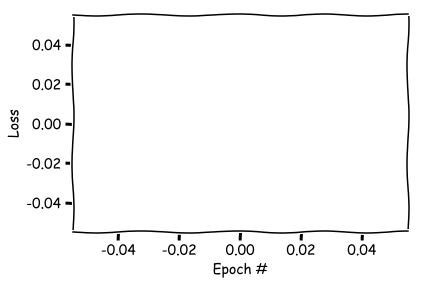

In [17]:
# visualize the loss from the training over the number of epochs
losses_in_epochs = losses[0::600]
plt.xkcd();
plt.xlabel('Epoch #');
plt.ylabel('Loss');
plt.plot(losses_in_epochs);
plt.show();

### Visualizing the Filters

In [ ]:
# In a convolutional network, let the network learn the filters that help it classify an image. 
# For instance, network could identify edges by learning a filter that acts as an edge detector. 
# A more complicated one could learn to identify the handles on a bag.
# Let’s visualize the filters from the first layer and the second layer:
def plot_kernels(tensor, num_cols=6):
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(num_kernels):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i][0,:,:], cmap='gray')
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()
filters = cnn.modules();
model_layers = [i for i in cnn.children()];
first_layer = model_layers[0];
second_layer = model_layers[1];
first_kernels = first_layer[0].weight.data.numpy()
plot_kernels(first_kernels, 8)
second_kernels = second_layer[0].weight.data.numpy()
plot_kernels(second_kernels, 8)